In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-12-27 16:35:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.101.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   109MB/s    in 4.1s    

2023-12-27 16:35:59 (120 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



**Import necessary modules:**

In [2]:
import zipfile
import os
import numpy as np
import random
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

**Unzip Data:**

In [3]:
zip_ref = zipfile.ZipFile('10_food_classes_all_data.zip')
zip_ref.extractall()
zip_ref.close()

**Check for the number of images in each classes of training and test datasets:**

In [4]:
for dirpath, dirnames, filenames in os.walk('10_food_classes_all_data'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_all_data
There are 10 directories and 0 images in 10_food_classes_all_data/train
There are 0 directories and 750 images in 10_food_classes_all_data/train/chicken_wings
There are 0 directories and 750 images in 10_food_classes_all_data/train/sushi
There are 0 directories and 750 images in 10_food_classes_all_data/train/grilled_salmon
There are 0 directories and 750 images in 10_food_classes_all_data/train/chicken_curry
There are 0 directories and 750 images in 10_food_classes_all_data/train/hamburger
There are 0 directories and 750 images in 10_food_classes_all_data/train/fried_rice
There are 0 directories and 750 images in 10_food_classes_all_data/train/ice_cream
There are 0 directories and 750 images in 10_food_classes_all_data/train/ramen
There are 0 directories and 750 images in 10_food_classes_all_data/train/steak
There are 0 directories and 750 images in 10_food_classes_all_data/train/pizza
There are 10 directories and 0 imag

**Check for the Class Names:**

In [5]:
data_dir = pathlib.Path('/content/10_food_classes_all_data/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


**Make a Function to view the random image:**

In [6]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + '/' + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    img = plt.imshow(img)
    plt.title(target_class)
    plt.axis(False)

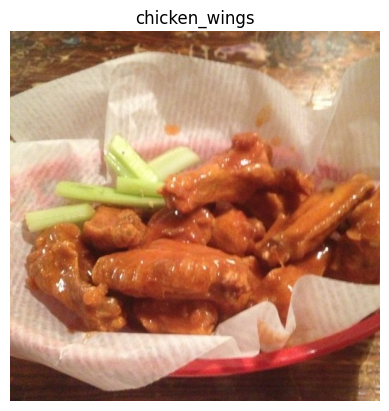

In [7]:
view_random_image('/content/10_food_classes_all_data/train', 'chicken_wings')

**Making the train and test datasets:**

> Batch_size = 32, label_mode = categorical, img_size = (224, 224), 'shuffle = True' for train_data and 'shuffle = False' for test dataset


In [8]:
IMG_SIZE = (224, 224)
train_dir = '/content/10_food_classes_all_data/train'
test_dir = '/content/10_food_classes_all_data/test'
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 batch_size = 32,
                                                                 label_mode = 'categorical',
                                                                 shuffle = True,
                                                                 image_size = IMG_SIZE,
                                                                 seed = 42)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                batch_size = 32,
                                                                label_mode = 'categorical',
                                                                shuffle = False,
                                                                image_size = IMG_SIZE,
                                                                seed = 42)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


**Create a data augmentation layer:/**

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomWidth(0.2)])

**Create a function to visualize our model's metrics:**

In [10]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(history.history['loss']))
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.plot(epochs, loss, label = 'Training Loss')
    plt.plot(epochs, val_loss, label = 'Validation Loss')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label = 'Training Accuracy')
    plt.plot(epochs, val_accuracy, label = 'Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.legend()

**Create a function to visualize model's metrics after fine tuning:**

In [11]:
def compare_historys(original_history, new_history, initial_epochs = 10):
    accuracy = original_history.history['accuracy']
    val_accuracy = original_history.history['val_accuracy']
    loss = original_history.history['loss']
    val_loss = original_history.history['val_loss']

    total_accuracy = accuracy + new_history.history['accuracy']
    total_val_accuracy = val_accuracy + new_history.history['val_accuracy']
    total_loss = loss + new_history.history['loss']
    total_val_loss = val_loss + new_history.history['val_loss']

    plt.plot(total_accuracy, label = 'Training accuracy')
    plt.plot(total_val_accuracy, label = 'Validation accuracy')
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label = 'fine tune epochs')
    plt.title('Training and validation accuracy')
    plt.legend();

    plt.figure()
    plt.plot(total_loss, label = 'Training loss')
    plt.plot(total_val_loss, label = 'Validation loss')
    plt.plot([initial_epochs - 1, initial_epochs -1], plt.ylim(), label = 'fine tune epochs')
    plt.title('Training and validation loss')
    plt.legend();


**Create a function to create a model checkpoint callback:**

> save_best_only = True, save_freq = 'epoch', restore_best_weights = True

In [12]:
checkpoint_path = 'model_checkpoints_weights/checkpoint.ckpt'
def create_checkpoint_callback(model_name, save_path = checkpoint_path):
    return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(checkpoint_path, model_name),
                                                         save_best_only = True,
                                                         save_freq = 'epoch',
                                                         verbose = 1,
                                                         restore_best_weights = True)

**Create a feature extractor model using EfficientnetV2B0 model:**

In [13]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape = input_shape, name = 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'GAP2D')(x)
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)
model_1 = tf.keras.Model(inputs, outputs, name = 'model_for_fine_tuning')
model_1.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_1 = model_1.fit(train_data,
            epochs = 10,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = int(0.25 * len(test_data)),
            callbacks = create_checkpoint_callback(model_name = model_1.name))

24274472/24274472 [==============================] - 0s 0us/step
Epoch 1/10
235/235 [==============================] - ETA: 0s - loss: 1.0642 - accuracy: 0.6864
Epoch 1: val_loss improved from inf to 0.63865, saving model to model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning
235/235 [==============================] - 234s 950ms/step - loss: 1.0642 - accuracy: 0.6864 - val_loss: 0.6386 - val_accuracy: 0.7911
Epoch 2/10
235/235 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.7943
Epoch 2: val_loss improved from 0.63865 to 0.49825, saving model to model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning
235/235 [==============================] - 151s 642ms/step - loss: 0.6780 - accuracy: 0.7943 - val_loss: 0.4983 - val_accuracy: 0.8289
Epoch 3/10
235/235 [==============================] - ETA: 0s - loss: 0.5993 - accuracy: 0.8159
Epoch 3: val_loss improved from 0.49825 to 0.43149, saving model to model_checkpoints_weights/checkpoint.ckpt/model_f

**Make evaluation on test Data:**

In [14]:
model_1.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.2844 - accuracy: 0.9040


[0.2844476103782654, 0.9039999842643738]

In [15]:
model_1 = tf.keras.models.load_model('/content/model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning')

In [16]:
model_1.evaluate(test_data)

79/79 [==============================] - 8s 74ms/step - loss: 0.2874 - accuracy: 0.9044


[0.28736045956611633, 0.9043999910354614]

**Plot the performance of our model:**

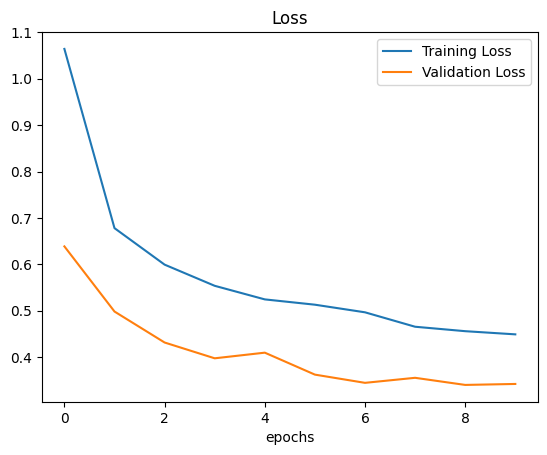

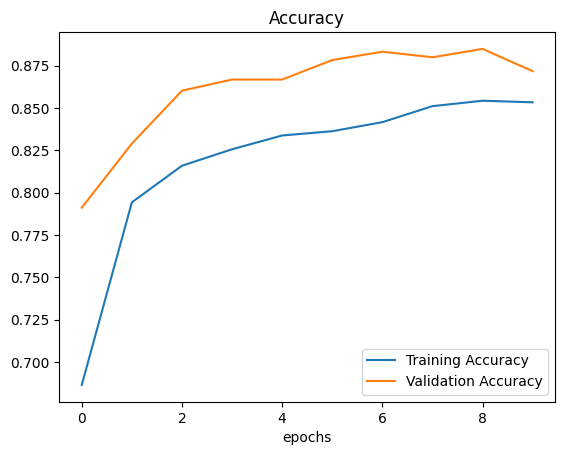

In [17]:
plot_loss_curves(history_1)

**Checkout the layers in our base model:**

In [18]:
for layer_number, layer in enumerate(model_1.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 True
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 False

**Fine tune for 20 layers by making last 20 layers in our base model trainable:**

In [19]:
model_1.layers[2].trainable = True
for layer in model_1.layers[2].layers[:-20]:
    layer.trainable = False

In [20]:
for layer_number, layer in enumerate(model_1.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

**Fine tune, compile our fine tuned model by lowering the learning late by 10x i.e. lr before = 0.001, lr after = 0.0001:, fit for another 12 epochs:**

In [21]:
model_1.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = 'accuracy')
history_2 = model_1.fit(train_data,
           epochs = 22,
           initial_epoch = history_1.epoch[-1],
           steps_per_epoch = len(train_data),
           validation_data = test_data,
           validation_steps = int(0.25 * len(test_data)))

Epoch 10/22
235/235 [==============================] - 37s 106ms/step - loss: 0.4235 - accuracy: 0.8640 - val_loss: 0.2707 - val_accuracy: 0.9112
Epoch 11/22
235/235 [==============================] - 50s 211ms/step - loss: 0.3868 - accuracy: 0.8709 - val_loss: 0.2729 - val_accuracy: 0.9046
Epoch 12/22
235/235 [==============================] - 49s 204ms/step - loss: 0.3598 - accuracy: 0.8812 - val_loss: 0.2655 - val_accuracy: 0.9161
Epoch 13/22
235/235 [==============================] - 43s 183ms/step - loss: 0.3238 - accuracy: 0.8924 - val_loss: 0.2639 - val_accuracy: 0.9243
Epoch 14/22
235/235 [==============================] - 44s 184ms/step - loss: 0.3036 - accuracy: 0.8995 - val_loss: 0.2673 - val_accuracy: 0.9128
Epoch 15/22
235/235 [==============================] - 40s 169ms/step - loss: 0.2832 - accuracy: 0.9080 - val_loss: 0.2213 - val_accuracy: 0.9326
Epoch 16/22
235/235 [==============================] - 38s 160ms/step - loss: 0.2613 - accuracy: 0.9157 - val_loss: 0.2290 -

**Compare the model's performance after fine tuning:**

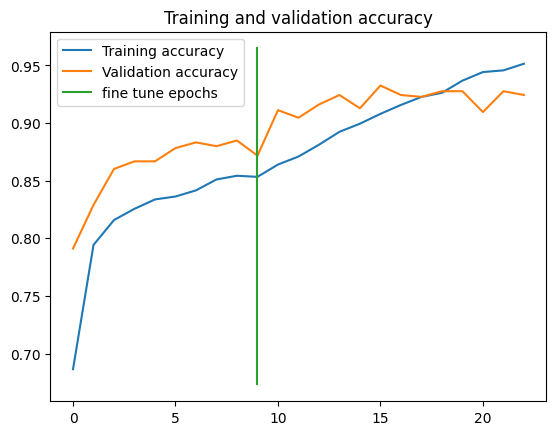

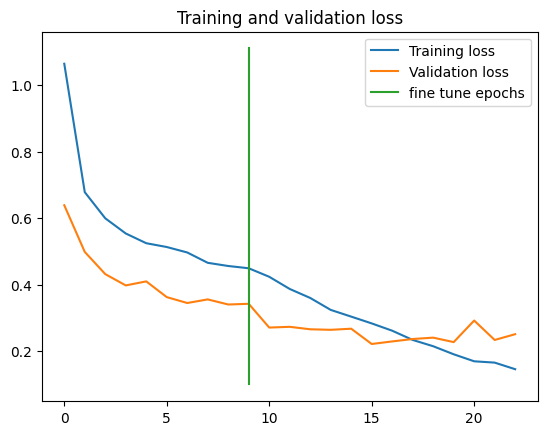

In [22]:
compare_historys(history_1, history_2)

**Evaluate on test data:**

In [23]:
model_1.evaluate(test_data)

79/79 [==============================] - 5s 65ms/step - loss: 0.2637 - accuracy: 0.9208


[0.26369422674179077, 0.920799970626831]

**Make prediction:**

In [24]:
model_1_pred_probs = model_1.predict(test_data)

79/79 [==============================] - 8s 65ms/step


**Check the labels of our predictions:**

In [25]:
model_1_preds = model_1_pred_probs.argmax(axis = 1)
model_1_preds

array([0, 7, 0, ..., 9, 9, 9])

**Unbatch the data and find out their labels:**

In [26]:
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())
y_labels[:3], y_labels[-3:]

([0, 0, 0], [9, 9, 9])

**Check for accuracy score:**

In [27]:
sklearn_accuracy = accuracy_score(y_labels, model_1_preds)
print(f"We're getting an accuracy of {sklearn_accuracy * 100}% on out test data")

We're getting an accuracy of 92.08% on out test data



**Check for the confusion metrics:**

In [28]:
conf_matrix = confusion_matrix(y_labels, model_1_preds)
conf_matrix

array([[224,   7,   3,   3,   2,   1,   0,  10,   0,   0],
       [  3, 242,   0,   1,   1,   0,   0,   0,   3,   0],
       [ 18,   0, 217,   1,   3,   1,   0,   6,   3,   1],
       [ 13,   5,   3, 199,   9,   1,   0,   5,  14,   1],
       [  0,   1,   0,   1, 242,   0,   0,   0,   6,   0],
       [  1,   3,   0,   0,   2, 240,   1,   0,   2,   1],
       [  4,   0,   0,   0,   3,   1, 242,   0,   0,   0],
       [  5,   0,   0,   1,   0,   0,   0, 243,   1,   0],
       [  3,   5,   1,  11,   7,   0,   0,   2, 221,   0],
       [  4,   0,   2,   6,   4,   0,   0,   1,   1, 232]])

In [29]:
class_names = test_data.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']


**Plot the confusioin metrics:**

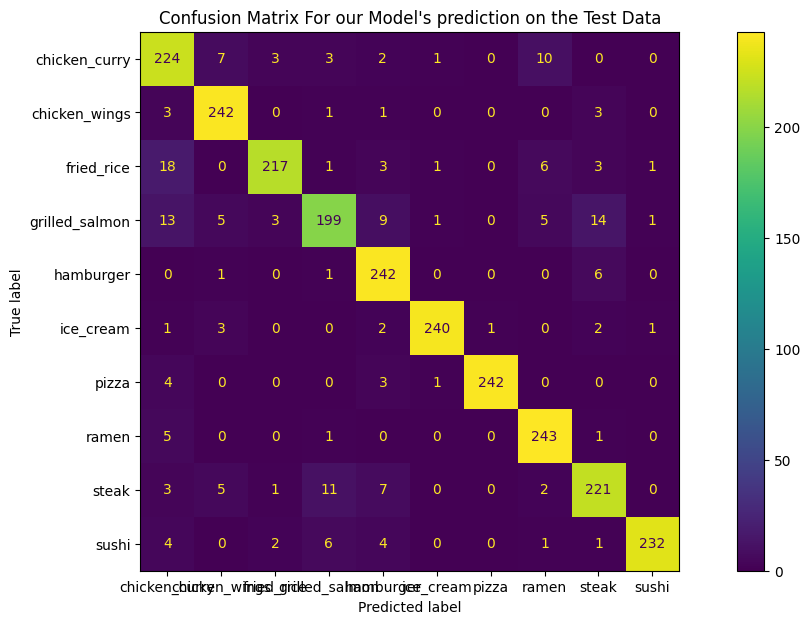

In [30]:
fig, ax = plt.subplots(figsize = (15, 7), dpi = 100)
display = ConfusionMatrixDisplay(conf_matrix, display_labels = class_names)
ax.set(title = "Confusion Matrix For our Model's prediction on the Test Data")
display.plot(ax = ax);

**A function to prepare our image for prediction:**

In [31]:
def load_and_prep_image(filename, img_shape = 224, scale = True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

**A function to make prediction and view our prediction:**

In [32]:
def pred_and_plot(model, filename, class_name = class_names):
  img = load_and_prep_image(filename, scale = False)
  pred_probs = model.predict(tf.expand_dims(img, axis = 0))
  pred_class = class_names[pred_probs.argmax()]
  plt.imshow(img/255.)
  plt.title(f"Pred class: {pred_class}")
  plt.axis(False)
  return pred_class

**Make some predictions from images downloaded from the wild:**

> 1.)

1/1 [==============================] - 3s 3s/step


'hamburger'

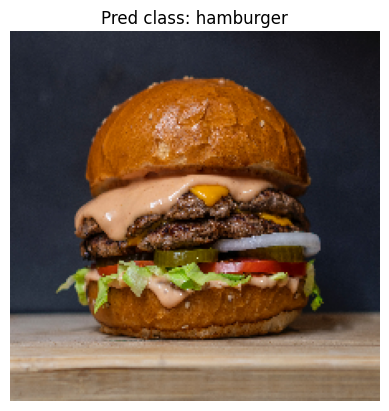

In [33]:
pred_and_plot(model_1, filename = '/content/amirali-mirhashemian-sc5sTPMrVfk-unsplash.jpg')

> 2.)

1/1 [==============================] - 0s 30ms/step


'chicken_curry'

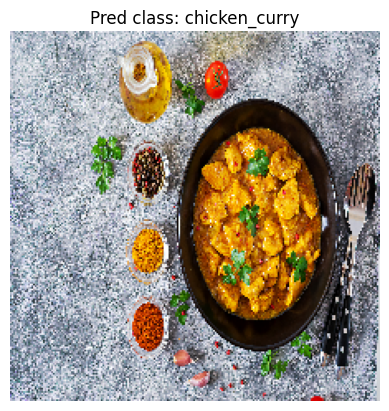

In [35]:
pred_and_plot(model_1, '/content/curry-with-chicken-onions-indian-food-asian-cuisine-top-view.jpg')



> 3.)





1/1 [==============================] - 0s 40ms/step


'pizza'

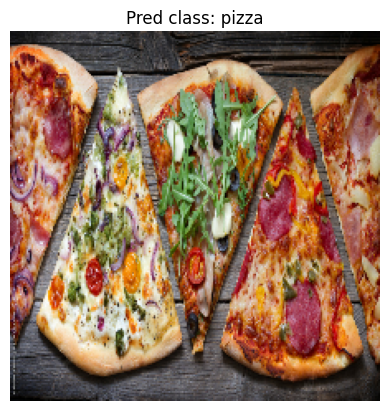

In [37]:
pred_and_plot(model_1, '/content/AdobeStock_229732806_Preview.jpeg')



> 4.)



1/1 [==============================] - 0s 28ms/step


'sushi'

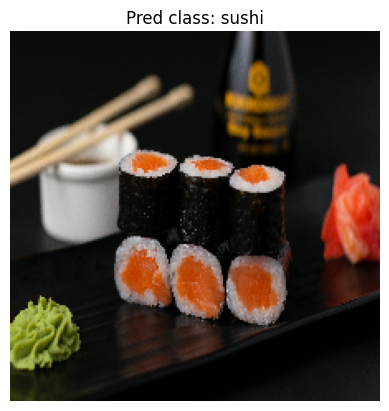

In [38]:
pred_and_plot(model_1, '/content/mahmoud-fawzy-FBezBX26dyY-unsplash.jpg')



> 5.)


1/1 [==============================] - 0s 28ms/step


'grilled_salmon'

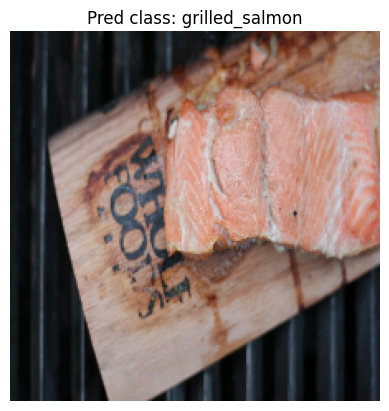

In [39]:
pred_and_plot(model_1, '/content/janeris-marte-RbE7eW-C8oU-unsplash.jpg')



> 6.)



1/1 [==============================] - 0s 29ms/step


'chicken_wings'

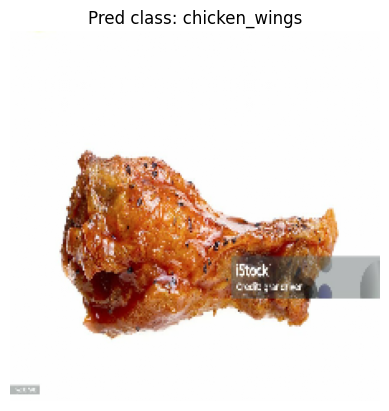

In [40]:
pred_and_plot(model_1, '/content/istockphoto-168307283-1024x1024.jpg')



> 7.)



1/1 [==============================] - 0s 53ms/step


'ice_cream'

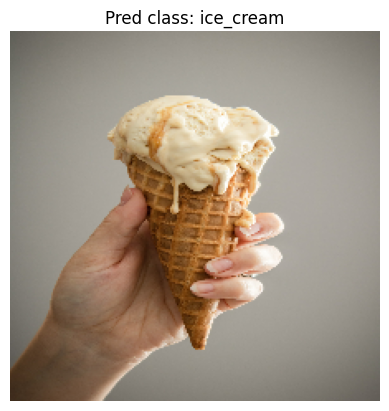

In [41]:
pred_and_plot(model_1, '/content/dana-devolk-5-RS_ScO3X4-unsplash.jpg')



> 8.)



1/1 [==============================] - 0s 29ms/step


'pizza'

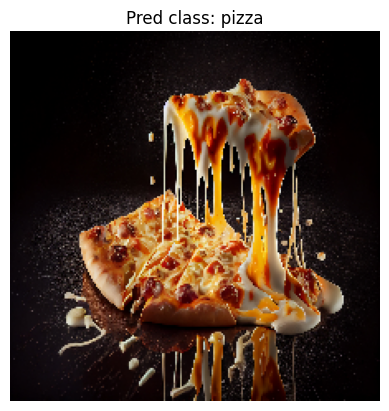

In [42]:
pred_and_plot(model_1, '/content/test_image_3.jpg')



> 9.)



1/1 [==============================] - 0s 40ms/step


'steak'

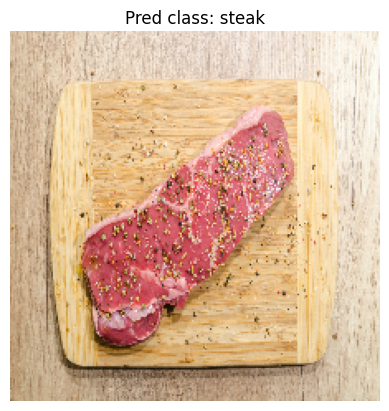

In [43]:
pred_and_plot(model_1, '/content/pexels-lukas-618775.jpg')